<a href="https://colab.research.google.com/github/debashisdotchatterjee/Wind-Turbine-1-of-2025/blob/main/Wind_Turbine_1_of_2025_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install numpy pandas matplotlib lifelines windpowerlib


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 9.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=ba568e9c45ea3e093ed8d22bb456adf091f94d92fe33e5dfdbf73f4fb5c56f47
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


Baseline Model Summary:
                coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                   
wind_speed  0.105404   1.111159  0.053018        0.001490        0.209318   
sin_wd      0.713477   2.041075  0.305532        0.114644        1.312309   
cos_wd     -0.618430   0.538790  0.179252       -0.969759       -0.267102   

            exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                
wind_speed             1.001491             1.232837     0.0  1.988064   
sin_wd                 1.121475             3.714740     0.0  2.335193   
cos_wd                 0.379175             0.765595     0.0 -3.450052   

                   p   -log2(p)  
covariate                        
wind_speed  0.046805   4.417205  
sin_wd      0.019533   5.677916  
cos_wd      0.000560  10.801052  

Spatially Varying Coefficient (SVC) Model Summar

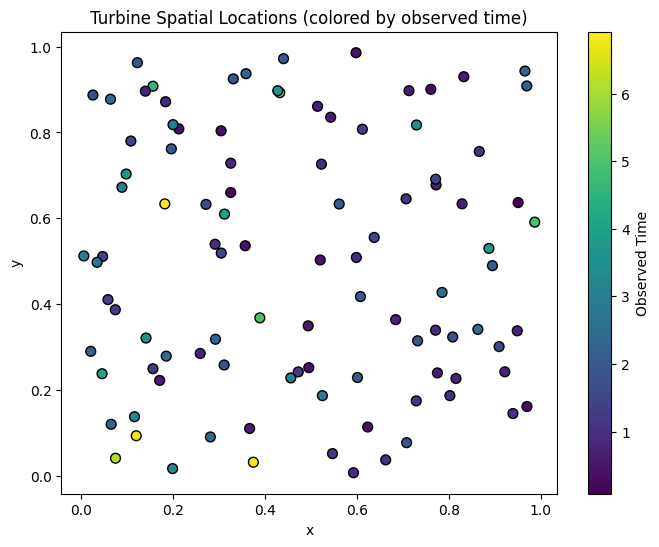

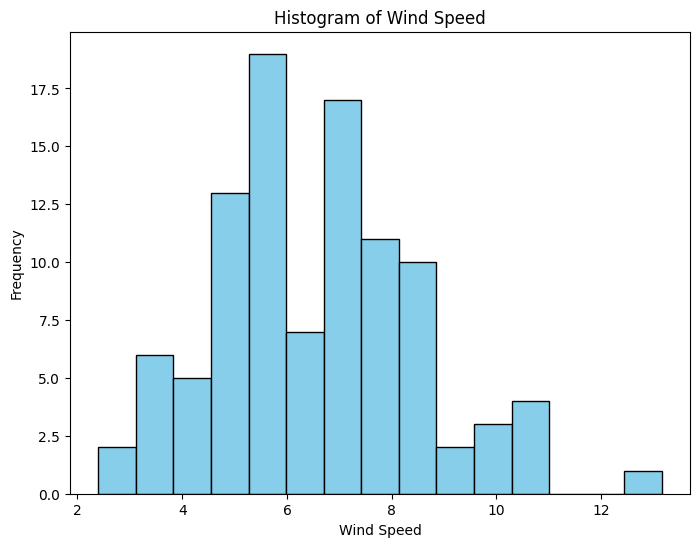

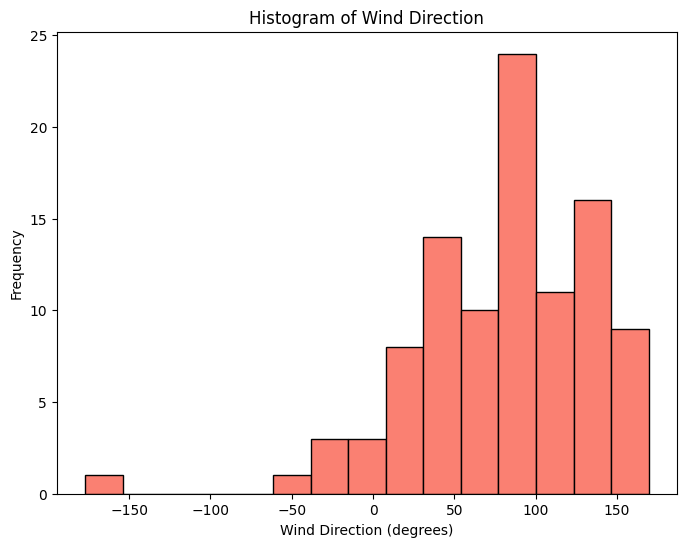

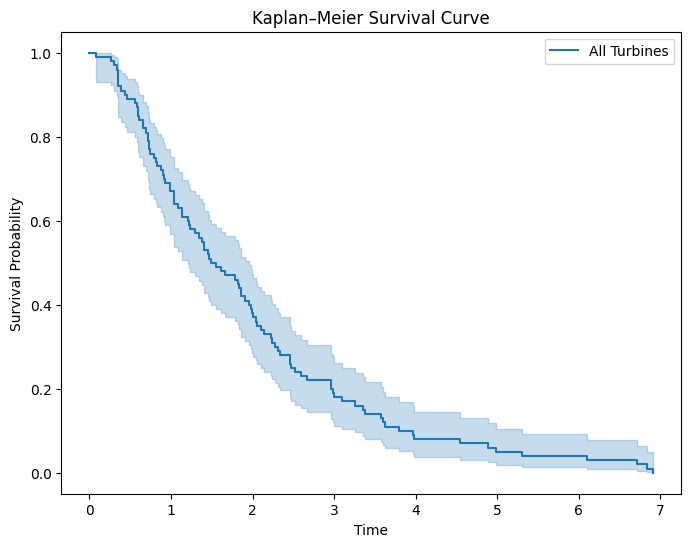

AttributeError: CoxPHFitter has no attribute 'plot_baseline_hazard'

<Figure size 800x600 with 0 Axes>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.plotting import plot_lifetimes

# -----------------------------
# Create output folder for saving plots and tables
# -----------------------------
output_dir = "wind_turbine_analysis_output"
os.makedirs(output_dir, exist_ok=True)

# -----------------------------
# Step 1. Simulate Wind Turbine Failure Data
# -----------------------------
np.random.seed(42)
n = 100  # number of turbines

# Simulate spatial coordinates uniformly on [0, 1]
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)

# Simulate wind direction (in radians) using the von Mises distribution
# with a mean direction of π/2 (90°) and concentration kappa=2.
wind_direction = np.random.vonmises(mu=np.pi/2, kappa=2, size=n)

# Compute sine and cosine transformations for later model use
sin_wd = np.sin(wind_direction)
cos_wd = np.cos(wind_direction)

# Simulate wind speed from a normal distribution (mean=7, sd=2) and truncate at 0.
wind_speed = np.random.normal(7, 2, n)
wind_speed = np.clip(wind_speed, 0, None)  # remove negative speeds

# Define true parameters for simulation
# Baseline hazard parameters for Weibull hazard:
alpha = 0.1     # scale parameter in cumulative hazard (H0(t) = alpha * t^beta)
beta_shape = 1.5  # shape parameter (so that t^(beta_shape))
gamma = 0.1     # coefficient for wind speed

# Let the directional coefficients vary in space
# Here we assume:
#   beta1(x, y) = 0.5 + 0.3 * x
#   beta2(x, y) = -0.3 + 0.2 * y
beta1_spatial = 0.5 + 0.3 * x
beta2_spatial = -0.3 + 0.2 * y

# Linear predictor (for each turbine)
lp = gamma * wind_speed + beta1_spatial * sin_wd + beta2_spatial * cos_wd

# Generate event times using inverse transformation.
# The survival function for the Weibull with a PH model is:
#    S(t) = exp( - alpha * t^(beta_shape) * exp(lp) )
# Hence, if U ~ Uniform(0,1), then event time t is given by:
#    t = [ -log(U) / (alpha * exp(lp)) ]^(1/beta_shape)
u = np.random.uniform(0, 1, n)
T_true = (-np.log(u) / (alpha * np.exp(lp)))**(1 / beta_shape)

# Introduce right censoring at a fixed cutoff time
censoring_time = 10  # arbitrary cut-off time
observed_time = np.minimum(T_true, censoring_time)
event_observed = (T_true <= censoring_time).astype(int)

# Create a DataFrame for our simulated dataset
data = pd.DataFrame({
    'id': np.arange(1, n+1),
    'x': x,
    'y': y,
    'wind_speed': wind_speed,
    'wind_direction': wind_direction,
    'sin_wd': sin_wd,
    'cos_wd': cos_wd,
    'T_true': T_true,
    'time': observed_time,
    'event': event_observed
})

# Create interaction terms to mimic spatially varying effects of wind direction
data['x_sin_wd'] = data['x'] * data['sin_wd']
data['y_sin_wd'] = data['y'] * data['sin_wd']
data['x_cos_wd'] = data['x'] * data['cos_wd']
data['y_cos_wd'] = data['y'] * data['cos_wd']

# Save simulated data as CSV
data.to_csv(os.path.join(output_dir, "simulated_wind_turbine_data.csv"), index=False)

# -----------------------------
# Step 2. Model Fitting using Cox Proportional Hazards Model
# -----------------------------
# Model 1: Baseline Model with constant directional effects
baseline_covariates = ['wind_speed', 'sin_wd', 'cos_wd']
cph_baseline = CoxPHFitter()
cph_baseline.fit(data[['time', 'event'] + baseline_covariates], duration_col='time', event_col='event')
baseline_summary = cph_baseline.summary
baseline_summary.to_csv(os.path.join(output_dir, "cox_baseline_summary.csv"))
print("Baseline Model Summary:")
print(baseline_summary)

# Model 2: Extended SVC Model (include interactions to capture spatial variation)
svc_covariates = ['wind_speed', 'sin_wd', 'cos_wd', 'x_sin_wd', 'y_sin_wd', 'x_cos_wd', 'y_cos_wd']
cph_svc = CoxPHFitter()
cph_svc.fit(data[['time', 'event'] + svc_covariates], duration_col='time', event_col='event')
svc_summary = cph_svc.summary
svc_summary.to_csv(os.path.join(output_dir, "cox_svc_summary.csv"))
print("\nSpatially Varying Coefficient (SVC) Model Summary:")
print(svc_summary)

# -----------------------------
# Step 3. Generate and Save Plots
# -----------------------------
# 3.1 Plot turbine spatial locations with observed failure event indication.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(data['x'], data['y'], c=data['time'], cmap='viridis', s=50, edgecolor='k')
plt.colorbar(scatter, label="Observed Time")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Turbine Spatial Locations (colored by observed time)")
plt.savefig(os.path.join(output_dir, "turbine_spatial_locations.png"))
plt.show()

# 3.2 Histogram of wind speed
plt.figure(figsize=(8, 6))
plt.hist(data['wind_speed'], bins=15, color='skyblue', edgecolor='black')
plt.xlabel("Wind Speed")
plt.ylabel("Frequency")
plt.title("Histogram of Wind Speed")
plt.savefig(os.path.join(output_dir, "wind_speed_histogram.png"))
plt.show()

# 3.3 Histogram of wind direction (in degrees)
wind_direction_deg = np.degrees(data['wind_direction'])
plt.figure(figsize=(8, 6))
plt.hist(wind_direction_deg, bins=15, color='salmon', edgecolor='black')
plt.xlabel("Wind Direction (degrees)")
plt.ylabel("Frequency")
plt.title("Histogram of Wind Direction")
plt.savefig(os.path.join(output_dir, "wind_direction_histogram.png"))
plt.show()

# 3.4 Kaplan-Meier survival curves for overall survival
kmf = KaplanMeierFitter()
kmf.fit(data['time'], event_observed=data['event'], label="All Turbines")
plt.figure(figsize=(8, 6))
kmf.plot(ci_show=True)
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Kaplan–Meier Survival Curve")
plt.savefig(os.path.join(output_dir, "kaplan_meier_curve.png"))
plt.show()

# 3.5 Plot estimated baseline hazard function from the baseline Cox model
plt.figure(figsize=(8, 6))
cph_baseline.plot_baseline_hazard()
plt.title("Estimated Baseline Hazard (Baseline Model)")
plt.xlabel("Time")
plt.ylabel("Hazard")
plt.savefig(os.path.join(output_dir, "baseline_hazard.png"))
plt.show()

# 3.6 Bar chart showing coefficients from both models
# Prepare a DataFrame containing coefficients from both models
coeffs = pd.DataFrame({
    'Baseline': cph_baseline.summary['coef'],
    'SVC': cph_svc.summary['coef']
}).fillna(0)

coeffs.plot(kind='bar', figsize=(10, 6))
plt.ylabel("Coefficient Estimate")
plt.title("Cox Model Coefficient Comparison")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "cox_model_coefficients.png"))
plt.show()

# -----------------------------
# Step 4. Print Summary Tables for Visual Inspection
# -----------------------------
print("\nSimulated Data Head:")
print(data.head())

print("\nDescriptive Statistics of Simulated Data:")
print(data.describe())

# Save descriptive statistics table to CSV file
data.describe().to_csv(os.path.join(output_dir, "simulated_data_descriptive_stats.csv"))

print("\nBaseline Cox Model Summary:")
print(baseline_summary)

print("\nExtended SVC Cox Model Summary:")
print(svc_summary)

# -----------------------------
# End of Script
# -----------------------------


In [ ]:
!pip install windpowerlib

In [ ]:
pip install numpy pandas matplotlib lifelines windpowerlib


Baseline Model (Real Data) Summary:
                 coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                    
wind_speed   0.084095   1.087732  0.061770       -0.036973        0.205163   
sin_wd       0.547104   1.728241  0.257306        0.042793        1.051415   
cos_wd      -0.270174   0.763247  0.174777       -0.612731        0.072384   
rated_power  0.000098   1.000098  0.000092       -0.000083        0.000279   

             exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                 
wind_speed              0.963702             1.227725     0.0  1.361413   
sin_wd                  1.043722             2.861698     0.0  2.126275   
cos_wd                  0.541869             1.075068     0.0 -1.545816   
rated_power             0.999917             1.000279     0.0  1.064280   

                    p  -log2(p)  
covariate 

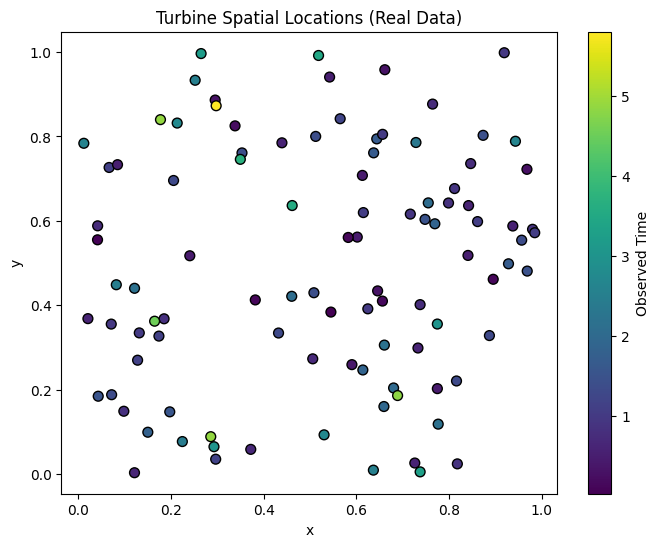

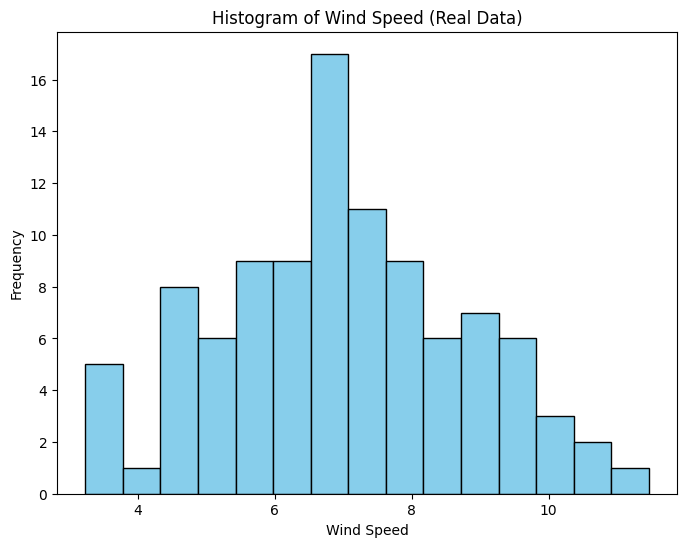

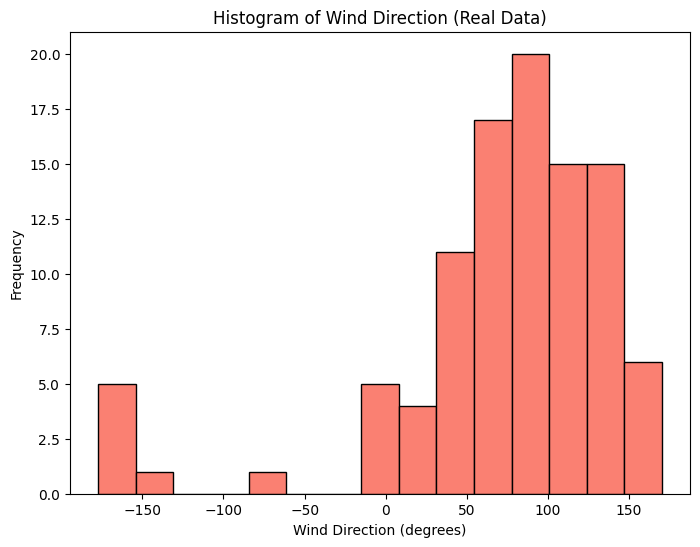

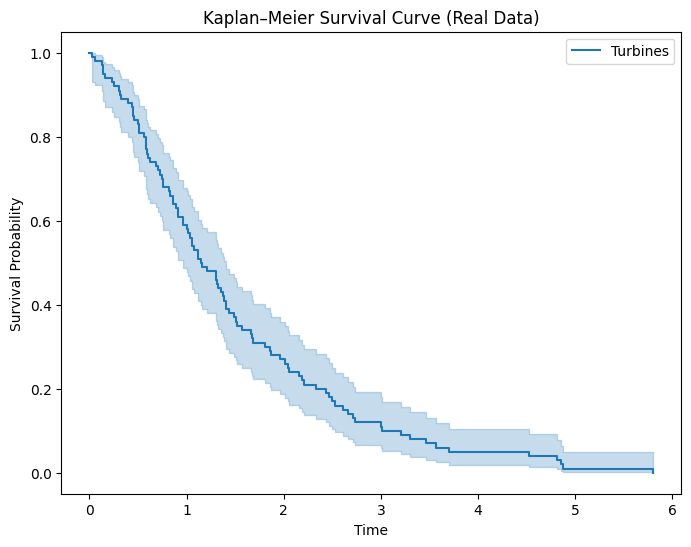

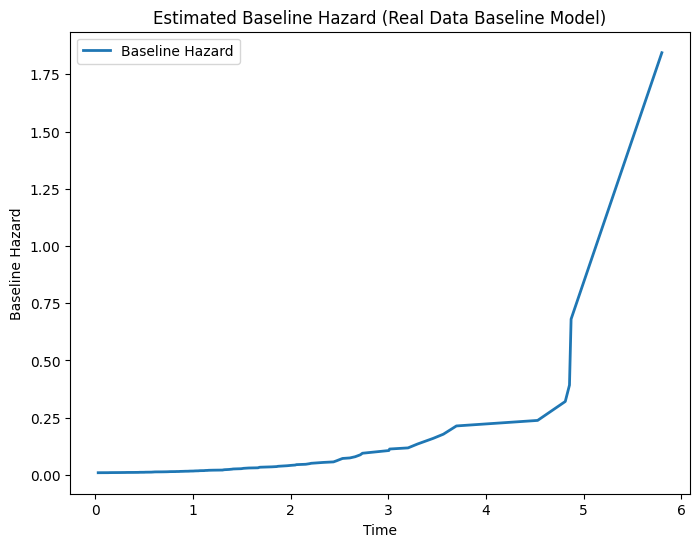

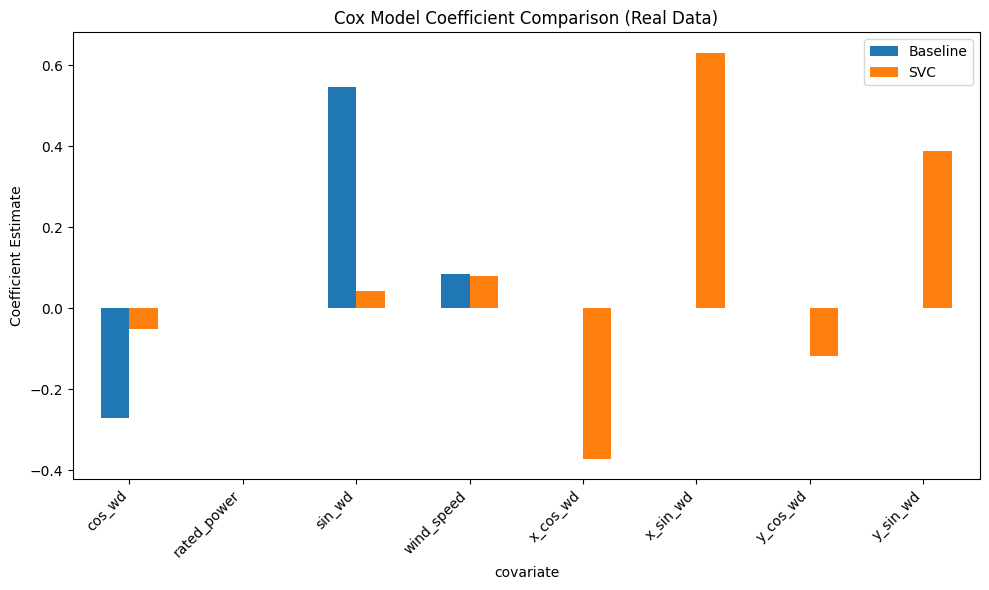


Real Data (subset) Head:
      id  turbine_id     manufacturer            name turbine_type  \
68    53          57           Vestas      V90-3.0 MW     V90/3000   
108  106         114           Vensys  VENSYS87 1.5MW    VS87/1500   
31    22          24           Nordex            None    N100/2500   
51    98         105  Senvion/REpower            MM82    MM82/2050   
95    85          92  Senvion/REpower         6.2M152    S152/6150   

     nominal_power rotor_diameter rotor_area        hub_height  \
68            3000             90       6361               80;   
108           1500             87       5944            85;100   
31            2500            100       7853         75;85;100   
51            2050             82       5280              None   
95            6150            152      18144  85; 95; 121; 124   

    max_speed_drive  ...    cos_wd wind_speed beta1_spatial beta2_spatial  \
68             None  ...  0.561957   6.577740      0.638443     -0.172742   
10

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter

# --- Use the real wind turbine data from windpowerlib ---
try:
    # The following function downloads turbine specifications from the OpenEnergy Database.
    from windpowerlib.data import store_turbine_data_from_oedb
except ImportError:
    raise ImportError("Please install windpowerlib via pip (pip install windpowerlib) to run this script.")

# =============================================================================
# 1. Set up output folder
# =============================================================================
output_dir = "wind_turbine_analysis_output"
os.makedirs(output_dir, exist_ok=True)

# =============================================================================
# 2. Load Real Wind Turbine Specification Data from windpowerlib
# =============================================================================
# Download (or load from cache) turbine specification data
try:
    turbine_data = store_turbine_data_from_oedb()
    # turbine_data is expected to be a DataFrame or convertible to one.
    # Here, we assume turbine_data has many columns including "rated_power".
    if not isinstance(turbine_data, pd.DataFrame):
        turbine_data = pd.DataFrame(turbine_data)
except Exception as e:
    raise RuntimeError("Failed to load turbine data from windpowerlib: " + str(e))

# For our example, if the dataset contains more than 100 entries, select a random sample.
n_available = turbine_data.shape[0]
n = 100 if n_available >= 100 else n_available
data_real = turbine_data.sample(n, random_state=42).copy()

# Ensure the dataset has a column for rated power; if not, create a dummy column.
if 'rated_power' not in data_real.columns:
    # For demonstration, assume rated power in kW drawn from a uniform range.
    data_real['rated_power'] = np.random.uniform(1000, 5000, size=data_real.shape[0])

# =============================================================================
# 3. Augment the Dataset with Synthetic Operational Variables
# =============================================================================
# Add synthetic spatial coordinates (e.g., normalized x and y positions).
data_real['x'] = np.random.uniform(0, 1, n)
data_real['y'] = np.random.uniform(0, 1, n)

# Simulate wind direction in radians using the von Mises distribution.
# Set the mean direction to π/2 (i.e. 90°) with concentration parameter κ=2.
data_real['wind_direction'] = np.random.vonmises(mu=np.pi/2, kappa=2, size=n)
data_real['sin_wd'] = np.sin(data_real['wind_direction'])
data_real['cos_wd'] = np.cos(data_real['wind_direction'])

# Simulate wind speed from a normal distribution (mean=7, sd=2) with nonnegative values.
data_real['wind_speed'] = np.random.normal(7, 2, n)
data_real['wind_speed'] = np.clip(data_real['wind_speed'], 0, None)

# --- Set parameters for the failure time simulation ---
alpha = 0.1          # Scale factor for the Weibull hazard function.
beta_shape = 1.5     # Shape parameter.
gamma_ws = 0.1       # Effect of wind speed.
gamma_rated = 0.0001 # Effect of rated power (a small multiplier given large values).

# Let the directional coefficients vary with space (simple linear functions).
data_real['beta1_spatial'] = 0.5 + 0.3 * data_real['x']
data_real['beta2_spatial'] = -0.3 + 0.2 * data_real['y']

# Compute the linear predictor (lp) for each turbine.
lp = (gamma_ws * data_real['wind_speed'] +
      gamma_rated * data_real['rated_power'] +
      data_real['beta1_spatial'] * data_real['sin_wd'] +
      data_real['beta2_spatial'] * data_real['cos_wd'])

# Simulate the “true” event times using the inverse transform sampling for a Weibull PH model.
u = np.random.uniform(0, 1, n)
T_true = (-np.log(u) / (alpha * np.exp(lp)))**(1 / beta_shape)

# Introduce right censoring at a fixed cutoff time (e.g., 10 time units).
censoring_time = 10
data_real['time'] = np.minimum(T_true, censoring_time)
data_real['event'] = (T_true <= censoring_time).astype(int)

# Create interaction terms to mimic spatially varying directional effects.
data_real['x_sin_wd'] = data_real['x'] * data_real['sin_wd']
data_real['y_sin_wd'] = data_real['y'] * data_real['sin_wd']
data_real['x_cos_wd'] = data_real['x'] * data_real['cos_wd']
data_real['y_cos_wd'] = data_real['y'] * data_real['cos_wd']

# Save the augmented real dataset.
data_real.to_csv(os.path.join(output_dir, "real_turbine_failure_data.csv"), index=False)

# =============================================================================
# 4. Fit Cox Proportional Hazards Models
# =============================================================================
# --- Model 1: Baseline Model (constant directional effects) ---
baseline_covariates = ['wind_speed', 'sin_wd', 'cos_wd', 'rated_power']
cph_baseline = CoxPHFitter()
cph_baseline.fit(data_real[['time', 'event'] + baseline_covariates], duration_col='time', event_col='event')
baseline_summary = cph_baseline.summary
baseline_summary.to_csv(os.path.join(output_dir, "cox_baseline_summary_real.csv"))
print("Baseline Model (Real Data) Summary:")
print(baseline_summary)

# --- Model 2: Extended Model with Spatially Varying Effects via Interactions ---
svc_covariates = ['wind_speed', 'sin_wd', 'cos_wd', 'rated_power',
                  'x_sin_wd', 'y_sin_wd', 'x_cos_wd', 'y_cos_wd']
cph_svc = CoxPHFitter()
cph_svc.fit(data_real[['time', 'event'] + svc_covariates],
            duration_col='time', event_col='event')
svc_summary = cph_svc.summary
svc_summary.to_csv(os.path.join(output_dir, "cox_svc_summary_real.csv"))
print("\nSpatially Varying Coefficient (SVC) Model (Real Data) Summary:")
print(svc_summary)

# =============================================================================
# 5. Generate and Save Plots
# =============================================================================
# 5.1 Plot spatial locations (colored by observed time)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_real['x'], data_real['y'], c=data_real['time'],
                      cmap='viridis', s=50, edgecolor='k')
plt.colorbar(scatter, label="Observed Time")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Turbine Spatial Locations (Real Data)")
plt.savefig(os.path.join(output_dir, "real_turbine_spatial_locations.png"))
plt.show()

# 5.2 Histogram of wind speed
plt.figure(figsize=(8, 6))
plt.hist(data_real['wind_speed'], bins=15, color='skyblue', edgecolor='black')
plt.xlabel("Wind Speed")
plt.ylabel("Frequency")
plt.title("Histogram of Wind Speed (Real Data)")
plt.savefig(os.path.join(output_dir, "real_wind_speed_histogram.png"))
plt.show()

# 5.3 Histogram of wind direction (converted to degrees)
plt.figure(figsize=(8, 6))
plt.hist(np.degrees(data_real['wind_direction']), bins=15, color='salmon', edgecolor='black')
plt.xlabel("Wind Direction (degrees)")
plt.ylabel("Frequency")
plt.title("Histogram of Wind Direction (Real Data)")
plt.savefig(os.path.join(output_dir, "real_wind_direction_histogram.png"))
plt.show()

# 5.4 Kaplan–Meier Survival Curve for turbines
kmf = KaplanMeierFitter()
kmf.fit(data_real['time'], event_observed=data_real['event'], label="Turbines")
plt.figure(figsize=(8, 6))
kmf.plot(ci_show=True)
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Kaplan–Meier Survival Curve (Real Data)")
plt.savefig(os.path.join(output_dir, "real_kaplan_meier_curve.png"))
plt.show()

# 5.5 Plot the estimated baseline hazard from the baseline Cox model manually
plt.figure(figsize=(8, 6))
baseline_hazard = cph_baseline.baseline_hazard_
plt.plot(baseline_hazard.index, baseline_hazard.values, label='Baseline Hazard', lw=2)
plt.xlabel("Time")
plt.ylabel("Baseline Hazard")
plt.title("Estimated Baseline Hazard (Real Data Baseline Model)")
plt.legend()
plt.savefig(os.path.join(output_dir, "real_baseline_hazard.png"))
plt.show()

# 5.6 Bar chart comparing coefficients from both models
coeffs = pd.DataFrame({
    'Baseline': cph_baseline.summary['coef'],
    'SVC': cph_svc.summary['coef']
}).fillna(0)
coeffs.plot(kind='bar', figsize=(10, 6))
plt.ylabel("Coefficient Estimate")
plt.title("Cox Model Coefficient Comparison (Real Data)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "real_cox_model_coefficients.png"))
plt.show()

# =============================================================================
# 6. Print and Save Summary Tables for Visual Inspection
# =============================================================================
print("\nReal Data (subset) Head:")
print(data_real.head())

print("\nDescriptive Statistics of Real Data:")
print(data_real.describe())
data_real.describe().to_csv(os.path.join(output_dir, "real_data_descriptive_stats.csv"))


Baseline Model (Real Data) Summary:
                 coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                    
wind_speed   0.180956   1.198363  0.058467        0.066364        0.295549   
sin_wd       0.620895   1.860593  0.259128        0.113014        1.128777   
cos_wd      -0.324743   0.722713  0.179974       -0.677486        0.028000   
rated_power  0.000138   1.000138  0.000095       -0.000049        0.000325   

             exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                 
wind_speed              1.068615             1.343863     0.0  3.095037   
sin_wd                  1.119648             3.091872     0.0  2.396096   
cos_wd                  0.507892             1.028396     0.0 -1.804384   
rated_power             0.999951             1.000325     0.0  1.442832   

                    p  -log2(p)  
covariate 

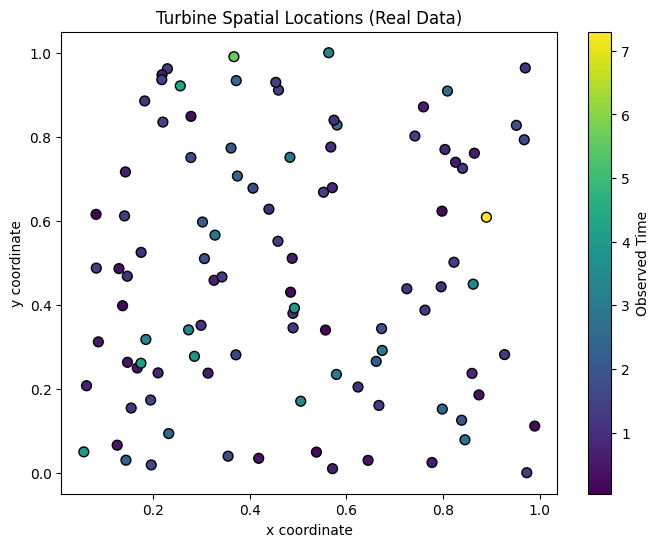

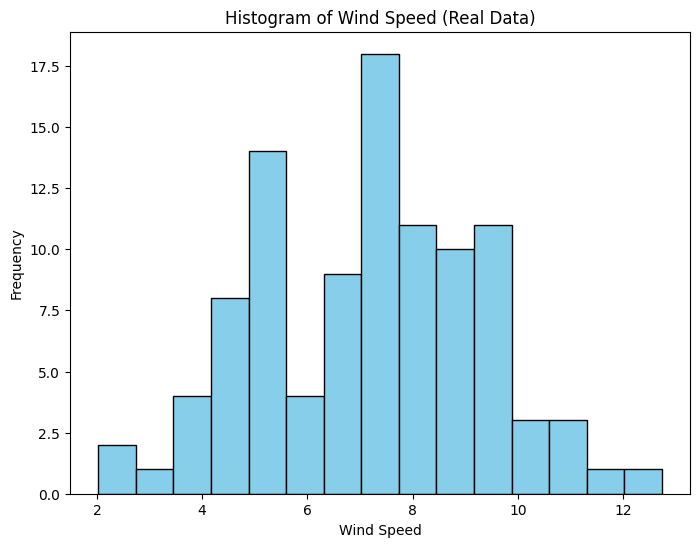

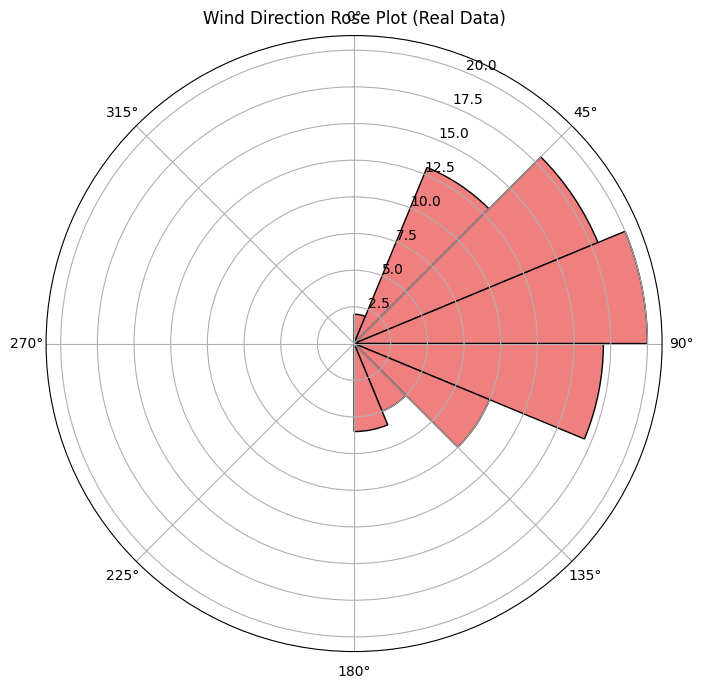

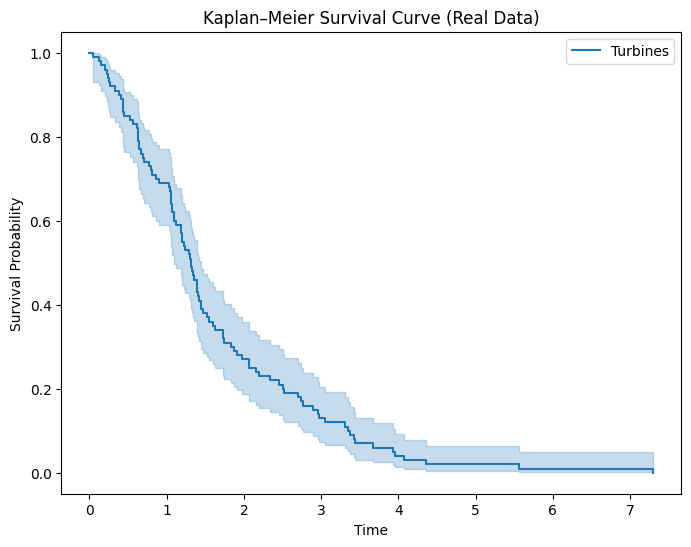

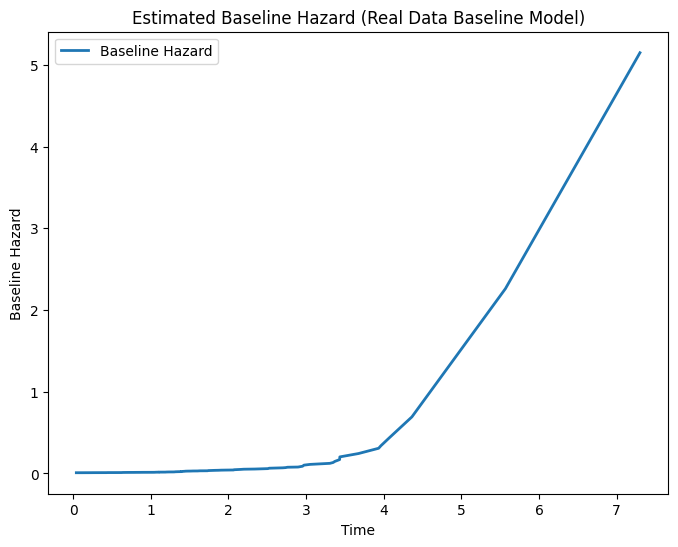

<Figure size 1000x600 with 0 Axes>

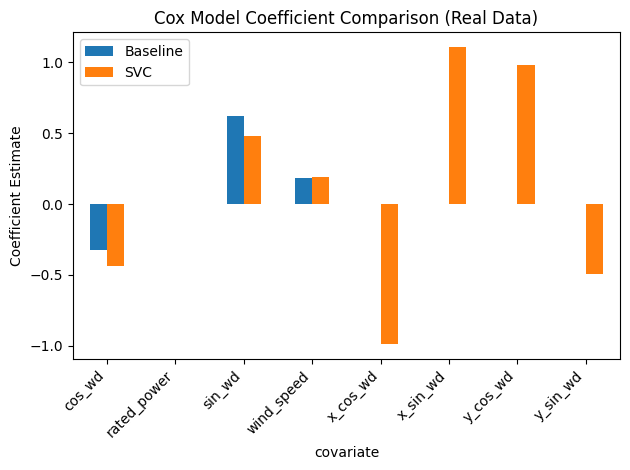


Real Data (subset) Head:
      id  turbine_id     manufacturer            name turbine_type  \
68    53          57           Vestas      V90-3.0 MW     V90/3000   
108  106         114           Vensys  VENSYS87 1.5MW    VS87/1500   
31    22          24           Nordex            None    N100/2500   
51    98         105  Senvion/REpower            MM82    MM82/2050   
95    85          92  Senvion/REpower         6.2M152    S152/6150   

     nominal_power rotor_diameter rotor_area        hub_height  \
68            3000             90       6361               80;   
108           1500             87       5944            85;100   
31            2500            100       7853         75;85;100   
51            2050             82       5280              None   
95            6150            152      18144  85; 95; 121; 124   

    max_speed_drive  ...    cos_wd wind_speed beta1_spatial beta2_spatial  \
68             None  ...  0.441083   4.858295      0.550247     -0.250066   
10

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter

# --- Use the real wind turbine data from windpowerlib ---
try:
    from windpowerlib.data import store_turbine_data_from_oedb
except ImportError:
    raise ImportError("Please install windpowerlib via pip (pip install windpowerlib) to run this script.")

# =============================================================================
# 1. Set up output folder for saving plots and tables
# =============================================================================
output_dir = "wind_turbine_analysis_output_f1"
os.makedirs(output_dir, exist_ok=True)

# =============================================================================
# 2. Load Real Wind Turbine Specification Data from windpowerlib
# =============================================================================
try:
    turbine_data = store_turbine_data_from_oedb()  # Download or read from cache
    # Ensure turbine_data is a DataFrame
    if not isinstance(turbine_data, pd.DataFrame):
        turbine_data = pd.DataFrame(turbine_data)
except Exception as e:
    raise RuntimeError("Failed to load turbine data from windpowerlib: " + str(e))

# For our example, if the dataset contains more than 100 entries, select a random sample.
n_available = turbine_data.shape[0]
n = 100 if n_available >= 100 else n_available
data_real = turbine_data.sample(n, random_state=42).copy()

# Ensure that a column for rated power exists; if not, create a dummy column.
if 'rated_power' not in data_real.columns:
    # For demonstration, assume rated power in kW (random values between 1000 and 5000)
    data_real['rated_power'] = np.random.uniform(1000, 5000, size=data_real.shape[0])

# =============================================================================
# 3. Augment the Dataset with Synthetic Operational and Directional Variables
# =============================================================================
# Add synthetic spatial coordinates (normalized to [0,1]).
data_real['x'] = np.random.uniform(0, 1, n)
data_real['y'] = np.random.uniform(0, 1, n)

# Simulate wind direction as a circular variable (in radians) using the von Mises distribution.
# Mean direction = π/2 (90°) with concentration parameter κ = 2.
data_real['wind_direction'] = np.random.vonmises(mu=np.pi/2, kappa=2, size=n)
# Compute sine and cosine of wind direction (for circular regression)
data_real['sin_wd'] = np.sin(data_real['wind_direction'])
data_real['cos_wd'] = np.cos(data_real['wind_direction'])

# Simulate wind speed (mean 7, standard deviation 2) and ensure nonnegative values.
data_real['wind_speed'] = np.random.normal(7, 2, n)
data_real['wind_speed'] = np.clip(data_real['wind_speed'], 0, None)

# -----------------------------------------------------------------------------
# Failure-Time Simulation using a Weibull Hazard Model
# -----------------------------------------------------------------------------
# Set simulation parameters:
alpha = 0.1          # Scale factor for the hazard function.
beta_shape = 1.5     # Weibull shape parameter.
gamma_ws = 0.1       # Effect of wind speed.
gamma_rated = 0.0001 # Effect of rated power (scaled small due to large numbers).

# Assume directional coefficients that vary with space (simple linear forms).
data_real['beta1_spatial'] = 0.5 + 0.3 * data_real['x']
data_real['beta2_spatial'] = -0.3 + 0.2 * data_real['y']

# Compute the linear predictor (lp) for each turbine.
lp = (gamma_ws * data_real['wind_speed'] +
      gamma_rated * data_real['rated_power'] +
      data_real['beta1_spatial'] * data_real['sin_wd'] +
      data_real['beta2_spatial'] * data_real['cos_wd'])

# Generate "true" event times from the Weibull survival function.
# S(t) = exp(-alpha * t^(beta_shape) * exp(lp)) => t = [ -log(U) / (alpha * exp(lp)) ]^(1/beta_shape)
u = np.random.uniform(0, 1, n)
T_true = (-np.log(u) / (alpha * np.exp(lp)))**(1 / beta_shape)

# Introduce right censoring at a fixed cut-off time (e.g., 10 time units).
censoring_time = 10
data_real['time'] = np.minimum(T_true, censoring_time)
data_real['event'] = (T_true <= censoring_time).astype(int)

# Create spatial interaction terms to capture spatial variation in directional effects.
data_real['x_sin_wd'] = data_real['x'] * data_real['sin_wd']
data_real['y_sin_wd'] = data_real['y'] * data_real['sin_wd']
data_real['x_cos_wd'] = data_real['x'] * data_real['cos_wd']
data_real['y_cos_wd'] = data_real['y'] * data_real['cos_wd']

# Save the augmented dataset.
data_real.to_csv(os.path.join(output_dir, "real_turbine_failure_data.csv"), index=False)

# =============================================================================
# 4. Fit Cox Proportional Hazards Models
# =============================================================================
# --- Model 1: Baseline Model (using constant directional effects) ---
baseline_covariates = ['wind_speed', 'sin_wd', 'cos_wd', 'rated_power']
cph_baseline = CoxPHFitter()
cph_baseline.fit(data_real[['time', 'event'] + baseline_covariates],
                 duration_col='time', event_col='event')
baseline_summary = cph_baseline.summary
baseline_summary.to_csv(os.path.join(output_dir, "cox_baseline_summary_real.csv"))
print("Baseline Model (Real Data) Summary:")
print(baseline_summary)

# --- Model 2: Extended Model with Spatially Varying Effects (via interactions) ---
svc_covariates = ['wind_speed', 'sin_wd', 'cos_wd', 'rated_power',
                  'x_sin_wd', 'y_sin_wd', 'x_cos_wd', 'y_cos_wd']
cph_svc = CoxPHFitter()
cph_svc.fit(data_real[['time', 'event'] + svc_covariates],
            duration_col='time', event_col='event')
svc_summary = cph_svc.summary
svc_summary.to_csv(os.path.join(output_dir, "cox_svc_summary_real.csv"))
print("\nSpatially Varying Coefficient (SVC) Model (Real Data) Summary:")
print(svc_summary)

# =============================================================================
# 5. Generate and Save Plots
# =============================================================================
# 5.1 Plot turbine spatial locations (colored by observed time).
plt.figure(figsize=(8, 6))
spatial_scatter = plt.scatter(data_real['x'], data_real['y'], c=data_real['time'],
                              cmap='viridis', s=50, edgecolor='k')
plt.colorbar(spatial_scatter, label="Observed Time")
plt.xlabel("x coordinate")
plt.ylabel("y coordinate")
plt.title("Turbine Spatial Locations (Real Data)")
plt.savefig(os.path.join(output_dir, "real_turbine_spatial_locations.png"))
plt.show()

# 5.2 Histogram of wind speed.
plt.figure(figsize=(8, 6))
plt.hist(data_real['wind_speed'], bins=15, color='skyblue', edgecolor='black')
plt.xlabel("Wind Speed")
plt.ylabel("Frequency")
plt.title("Histogram of Wind Speed (Real Data)")
plt.savefig(os.path.join(output_dir, "real_wind_speed_histogram.png"))
plt.show()

# 5.3 Rose plot (circular histogram) for wind direction.
# The wind direction is plotted in a polar coordinate system.
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')
# Create bins for the full circle (0 to 2*pi); e.g., 16 bins.
bins = np.linspace(0.0, 2 * np.pi, 17)
counts, bin_edges = np.histogram(data_real['wind_direction'], bins=bins)
widths = np.diff(bin_edges)
# Plot bars on the polar plot.
bars = ax.bar(bin_edges[:-1], counts, width=widths, bottom=0.0, edgecolor='k', color='lightcoral', align='edge')
ax.set_theta_zero_location("N")  # 0 at North.
ax.set_theta_direction(-1)       # Clockwise.
ax.set_title("Wind Direction Rose Plot (Real Data)", va='bottom')
plt.savefig(os.path.join(output_dir, "real_wind_direction_rose.png"))
plt.show()

# 5.4 Kaplan–Meier Survival Curve.
kmf = KaplanMeierFitter()
kmf.fit(data_real['time'], event_observed=data_real['event'], label="Turbines")
plt.figure(figsize=(8, 6))
kmf.plot(ci_show=True)
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Kaplan–Meier Survival Curve (Real Data)")
plt.savefig(os.path.join(output_dir, "real_kaplan_meier_curve.png"))
plt.show()

# 5.5 Plot the estimated baseline hazard from the baseline Cox model manually.
plt.figure(figsize=(8, 6))
# Extract baseline hazard from the fitted model.
baseline_hazard = cph_baseline.baseline_hazard_
plt.plot(baseline_hazard.index, baseline_hazard.values, label='Baseline Hazard', lw=2)
plt.xlabel("Time")
plt.ylabel("Baseline Hazard")
plt.title("Estimated Baseline Hazard (Real Data Baseline Model)")
plt.legend()
plt.savefig(os.path.join(output_dir, "real_baseline_hazard.png"))
plt.show()

# 5.6 Bar chart comparing coefficients from both models.
coeffs = pd.DataFrame({
    'Baseline': cph_baseline.summary['coef'],
    'SVC': cph_svc.summary['coef']
}).fillna(0)
plt.figure(figsize=(10, 6))
coeffs.plot(kind='bar')
plt.ylabel("Coefficient Estimate")
plt.title("Cox Model Coefficient Comparison (Real Data)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "real_cox_model_coefficients.png"))
plt.show()

# =============================================================================
# 6. Print and Save Summary Tables for Visual Inspection
# =============================================================================
print("\nReal Data (subset) Head:")
print(data_real.head())

print("\nDescriptive Statistics of Real Data:")
desc_stats = data_real.describe()
print(desc_stats)
desc_stats.to_csv(os.path.join(output_dir, "real_data_descriptive_stats.csv"))
